<a href="https://colab.research.google.com/github/numoworld/learnpytorchio/blob/main/03cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [226]:
# import libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.metrics import (precision_score, 
                             recall_score, 
                             f1_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay)

import matplotlib.pyplot as plt
from tqdm import tqdm

from timeit import default_timer as timer
from pathlib import Path

In [187]:
# define device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [188]:
# download dataset
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
    )

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

torch.Size([1, 28, 28])


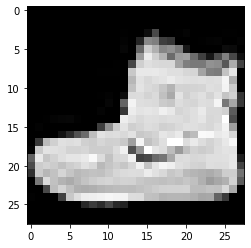

In [189]:
# inspect sample
image, label = train_data[0]
print(image.shape)  # BCHW
plt.imshow(image.squeeze(), cmap='gray')

In [190]:
# look at categories names
cat_names = train_data.classes
print(cat_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


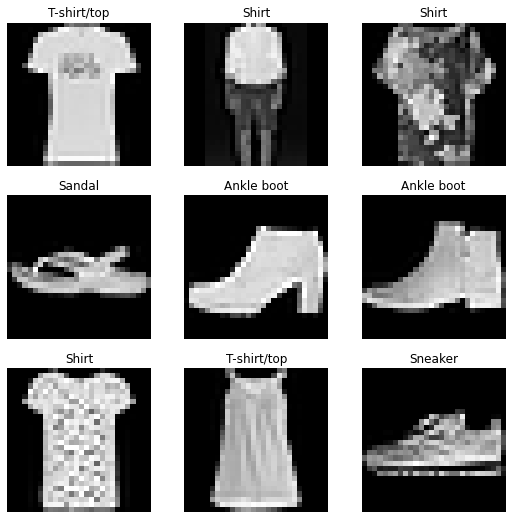

In [191]:
# display random images from set and their categories
rows, cols = 3, 3
fig = plt.figure(figsize=(9, 9))
for i in range(1, rows*cols + 1):
  index = torch.randint(high=len(train_data), size=[1]).item()
  img, label = train_data[index]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(cat_names[label])
  plt.axis(False)

In [192]:
# create dataloaders
BATCH_SIZE = 32

train_dl = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE
)
test_dl = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE
)

In [193]:
# inspect batches
bx, by = next(iter(train_dl))
bx.shape, by.shape, bx.device

(torch.Size([32, 1, 28, 28]), torch.Size([32]), device(type='cpu'))

In [194]:
# implement TinyVGG
class FashionModelV0(nn.Module):
    def __init__(self, in_channels, out_shape, hidden_units=10):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # look for generalized standard
            nn.Linear(in_features=hidden_units*7*7, out_features=out_shape)
        )
    def forward(self, x):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        return self.classifier(x)

torch.manual_seed(721)
model_0 = FashionModelV0(in_channels=1, out_shape=10).to(device)
model_0

FashionModelV0(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [195]:
# initialize loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [196]:
# define accuracy metric function
def acc_fn(pred, target):
    return (pred == target).sum() / len(pred) * 100

In [197]:
# define train step function
def train_step(
    model: torch.nn.Module,
    dl: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    acc_fn,
    device: str
) -> None:
    print('Training...')
    avg_loss, avg_acc = 0, 0
    model.train()
    for bn, (x, y) in enumerate(dl):
        x, y = x.to(device), y.to(device)
        
        logits = model(x)
        preds = torch.softmax(logits, dim=1).argmax(dim=1)

        loss = loss_fn(logits, y)
        avg_loss += loss

        avg_acc += acc_fn(preds, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        if bn % 400 == 0:
            print(f'Sample {bn*len(x)}/{len(dl.dataset)}')

    avg_loss /= len(dl)
    avg_acc /= len(dl)
    print(f'Train Loss: {avg_loss} | Train Accuracy: {avg_acc}\n')
    
# define test step function
def test_step(
    model: torch.nn.Module,
    dl: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn,
    device: str
) -> None:
    print('Testing...')  # should be validating
    avg_loss, avg_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for bn, (x, y) in enumerate(dl):
            x, y = x.to(device), y.to(device)
        
            logits = model(x)
            preds = torch.softmax(logits, dim=1).argmax(dim=1)

            loss = loss_fn(logits, y)
            avg_loss += loss

            avg_acc += acc_fn(preds, y)

            if bn % 400 == 0:
                print(f'Sample {bn*len(x)}/{len(dl.dataset)}')
        
        avg_loss /= len(dl)
        avg_acc /= len(dl)
        print(f'Test Loss: {avg_loss} | Test Accuracy: {avg_acc}\n')



In [198]:
# train loop
start_time = timer()

n_epochs = 3

for epoch in tqdm(range(1, n_epochs + 1)):
    print(f'\nEpoch {epoch}-----\n')
    
    # train step
    train_step(
        model=model_0,
        dl=train_dl,
        loss_fn=loss_fn,
        optimizer=optimizer,
        acc_fn=acc_fn,
        device=device
    )

    # test step
    test_step(
        model=model_0,
        dl=train_dl,
        loss_fn=loss_fn,
        acc_fn=acc_fn,
        device=device
    )

end_time = timer()
print(f'Time elapsed(s): {(end_time - start_time):3f}')



  0%|          | 0/3 [00:00<?, ?it/s]


Epoch 1-----

Training...
Sample 0/60000
Sample 12800/60000
Sample 25600/60000
Sample 38400/60000
Sample 51200/60000
Train Loss: 0.5841261744499207 | Train Accuracy: 78.65666961669922

Testing...
Sample 0/60000
Sample 12800/60000
Sample 25600/60000
Sample 38400/60000
Sample 51200/60000


 33%|███▎      | 1/3 [00:16<00:33, 16.91s/it]

Test Loss: 0.3720720112323761 | Test Accuracy: 86.38833618164062


Epoch 2-----

Training...
Sample 0/60000
Sample 12800/60000
Sample 25600/60000
Sample 38400/60000
Sample 51200/60000
Train Loss: 0.35466471314430237 | Train Accuracy: 87.06500244140625

Testing...
Sample 0/60000
Sample 12800/60000
Sample 25600/60000
Sample 38400/60000
Sample 51200/60000


 67%|██████▋   | 2/3 [00:34<00:17, 17.26s/it]

Test Loss: 0.3135056495666504 | Test Accuracy: 88.71500396728516


Epoch 3-----

Training...
Sample 0/60000
Sample 12800/60000
Sample 25600/60000
Sample 38400/60000
Sample 51200/60000
Train Loss: 0.3185146152973175 | Train Accuracy: 88.4183349609375

Testing...
Sample 0/60000
Sample 12800/60000
Sample 25600/60000
Sample 38400/60000
Sample 51200/60000


100%|██████████| 3/3 [00:52<00:00, 17.61s/it]

Test Loss: 0.29445093870162964 | Test Accuracy: 89.29499816894531

Time elapsed(s): 52.829169


In [201]:
# get other metrics

model_0.eval()
preds=[]
with torch.inference_mode():
    for x, y in tqdm(test_dl, desc='Making predictions.'):
        x, y = x.to(device), y.to(device)
        logits = model_0(x)
        batch_preds = torch.softmax(logits, dim=1).argmax(dim=1)
        preds.append(batch_preds.cpu())

preds = torch.cat(preds)

Making predictions.: 100%|██████████| 313/313 [00:02<00:00, 148.60it/s]


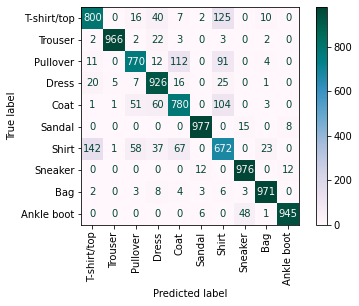

In [224]:
# plot confusion matrixa
cm = confusion_matrix(test_dl.dataset.targets, preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=test_dl.dataset.classes
    )
disp.plot(
    xticks_rotation='vertical',
    cmap='PuBuGn'
    )

plt.show()

In [231]:
# saving model

MODELS_DIR = Path('models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'CNN_FashionMNIST_Model_V0.pth'
MODEL_PATH = MODELS_DIR / MODEL_NAME

torch.save(obj=model_0.state_dict(), f=MODEL_PATH)
!ls models

CNN_FashionMNIST_Model_V0.pth


In [233]:
# loading model to check

loaded_model = FashionModelV0(in_channels=1, out_shape=10)

loaded_model.load_state_dict(torch.load(f=MODEL_PATH))

loaded_model.to(device)

FashionModelV0(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [236]:
# verify loaded model
loaded_model.eval()
loaded_model_preds=[]
with torch.inference_mode():
    for x, y in tqdm(test_dl, desc='Making predictions.'):
        x, y = x.to(device), y.to(device)
        logits = loaded_model(x)
        batch_preds = torch.softmax(logits, dim=1).argmax(dim=1)
        loaded_model_preds.append(batch_preds.cpu())

loaded_model_preds = torch.cat(loaded_model_preds)

Making predictions.: 100%|██████████| 313/313 [00:02<00:00, 149.21it/s]


In [240]:
(preds == loaded_model_preds).all()

tensor(True)